## Description

The issue with multi-armed bandits when we are dealing with a non-stationary
time series is that we can get a biased result based on our changing sampling
rates (see reference: https://www.unofficialgoogledatascience.com/2020/07/changing-assignment-weights-with-time.html).

To address this, we introduce a method to generate probability distribution
of average publisher revenue per hour and do a weighted average of the
distributions.  

In [2]:
## Set auto-reload
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

from prebid_optimizer.models import BetaLogNormalModel
from prebid_optimizer.reader import TSReader

# Read in data

In [4]:
DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S"
timeouts = {
    "lainey_gossip": [800, 1000, 1500, 2000, 2500],
    "samyonews": [1500, 1750, 2000, 2250, 2500]
}
config_ids = {
    "lainey_gossip": "d385ba19-47da-48e9-ab1b-cdfb4149118b",
    "samyonews": "8026d592-cfa2-4e3e-8fe4-751b2293bd94"
}

In [5]:
publisher = "lainey_gossip"
reader = TSReader(
    config_id=config_ids[publisher],
    source_table="ox-datascience-devint.prebid.auctions_raw_lainey_gossip",    
    configs_to_optimize={"bidderTimeout": timeouts[publisher]},
    gcp_project="ox-datascience-devint"
)

In [6]:
start_timestamp = datetime.strptime("2021-10-27 12:00:00", DATETIME_FORMAT)
end_timestamp = datetime.strptime("2021-10-28 12:00:00", DATETIME_FORMAT)
all_data = reader.get_data(start_timestamp, end_timestamp, True)

2021-10-27 12:00:00 2021-10-28 12:00:00 24


In [7]:
display(all_data.head())
display(all_data.shape)
display(all_data.describe())

,auction_hour,bidderTimeout,win,pubrev
0,9,1000,0,0
1,9,1000,0,0
2,9,1000,0,0
3,9,1000,0,0
4,9,1000,0,0


(468978, 4)

,auction_hour,bidderTimeout,win,pubrev
count,468978.000000,468978.000000,468978.000000,4.689780e+05
mean,8.329305,1458.306360,0.132968,2.911081e+05
std,4.974109,571.892474,0.339540,1.468860e+06
min,0.000000,600.000000,0.000000,0.000000e+00
25%,5.000000,1000.000000,0.000000,0.000000e+00
50%,8.000000,1500.000000,0.000000,0.000000e+00
75%,11.000000,2000.000000,0.000000,0.000000e+00
max,23.000000,2500.000000,1.000000,1.296000e+08


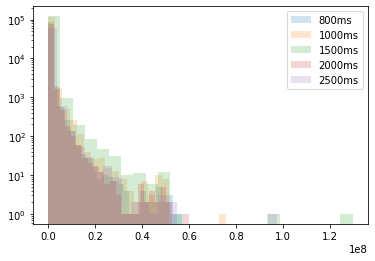

In [8]:
for timeout in timeouts[publisher]:
    sub_df = all_data[all_data["bidderTimeout"] == timeout]
    plt.hist(sub_df["pubrev"], bins=25, log=True, alpha=0.2, label=f"{timeout}ms")
    plt.legend()

In [9]:
all_data["auction_hour"].nunique()

24

# Fit model

In [10]:
def plot_rvs(all_data, timeout, max_hour=24, N=100000, verbose=False,
    pubrev_lo=0, pubrev_hi=1e6, use_global_mean=False
):
  
    hours = [hr for hr in range(max_hour)]
    df = all_data[all_data["bidderTimeout"]==timeout]
    
    global_means = []
    for hour in hours:
        hourly_mean = all_data[all_data["auction_hour"] == hour]["pubrev"].mean()
        global_means.append(hourly_mean)
    
    rvs = []
    if verbose:
        fig0, ax0 = plt.subplots(figsize=(9,9))
    total_n = 0
    model = BetaLogNormalModel()
    for hr in hours:
        hourly_df = df[df["auction_hour"] == hr]
        
        n = len(all_data[all_data["auction_hour"] == hr])
        total_n +=n

        global_hourly_mean = global_means[hr] if use_global_mean else 0
        rv = model.get_reward_distribution(hourly_df, n, global_hourly_mean)
        
        if verbose:
            _ = ax0.hist(
                    rv, 
                    label=f"{hr}hr, {n / 1000:.1f}k rows", 
                    bins=np.linspace(pubrev_lo, pubrev_hi, 100),
                    alpha=0.5)

        rvs.extend(rv)

    if verbose:
        ax0.legend()
        fig0.suptitle("RVs")
    
    sampled_rvs = np.random.choice(rvs, N)
    
    sub_df = df[df["auction_hour"] < max_hour + 1]
    global_mean_all = all_data["pubrev"].mean() if use_global_mean else 0
    rv_all = model.get_reward_distribution(sub_df, N, global_mean_all)    
    
    if verbose:
        fig1, ax1 = plt.subplots(1, 3, figsize=(15, 4))
        _ = ax1[0].hist(rvs, bins=np.linspace(pubrev_lo, pubrev_hi, 100))
        _ = ax1[1].hist(sampled_rvs, bins=np.linspace(pubrev_lo, pubrev_hi, 100))
        _ = ax1[2].hist(rv_all, bins=np.linspace(pubrev_lo, pubrev_hi, 100))
        ax1[0].set_title("Summed RVs")
        ax1[1].set_title("Sampled RVs")
        ax1[2].set_title("all RV")
    
    return sampled_rvs, rv_all

# Don't subtract global mean

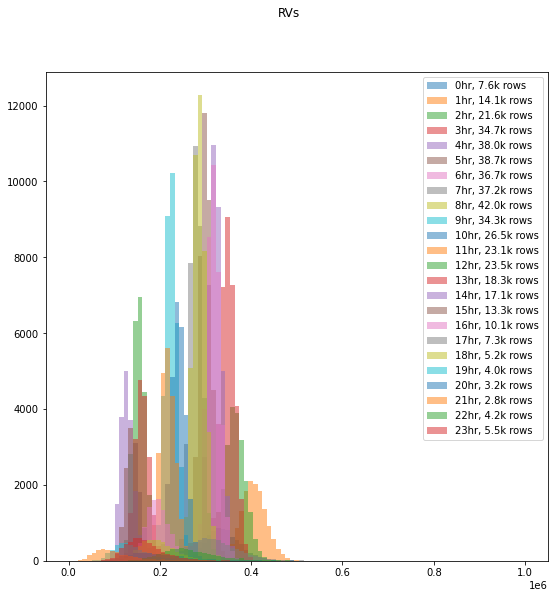

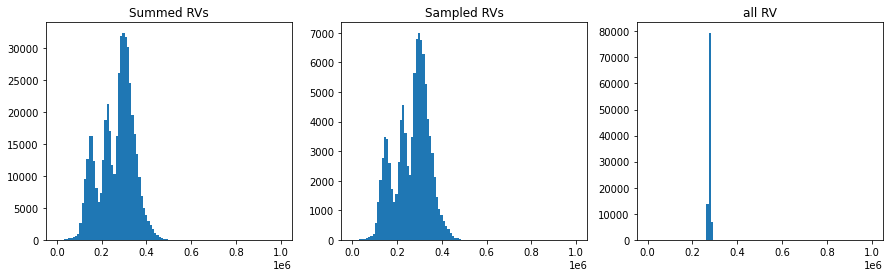

In [11]:
rvs_A, rvs_A_all = plot_rvs(all_data, timeout=800, max_hour=24, N=100000, verbose=True, 
                            pubrev_lo=0e6, pubrev_hi=1e6, use_global_mean=False)

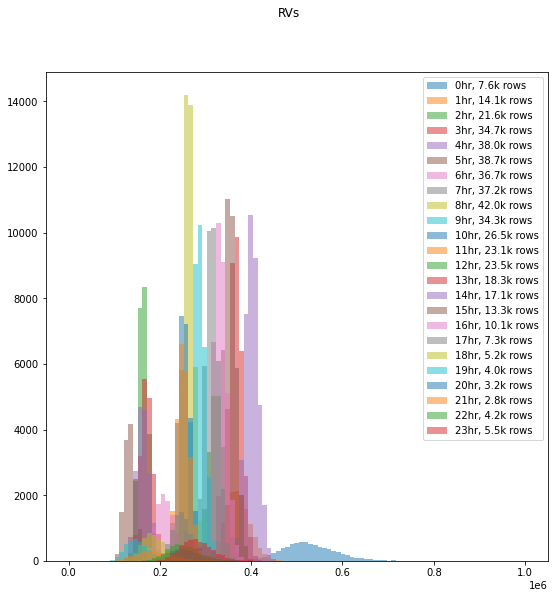

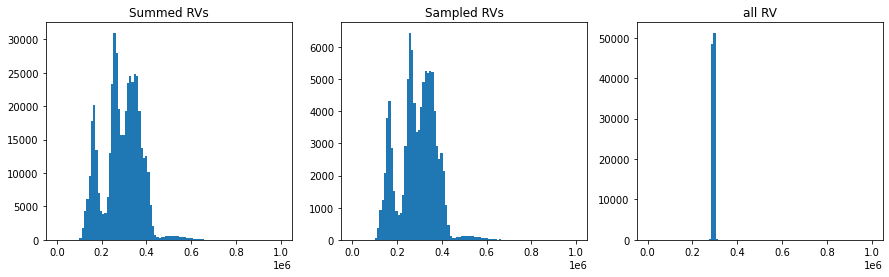

In [12]:
rvs_B, rvs_B_all = plot_rvs(all_data, timeout=1500, max_hour=24, N=100000, verbose=True, 
                            pubrev_lo=0e6, pubrev_hi=1e6, use_global_mean=False)

In [13]:
P = (rvs_A < rvs_B).sum() / len(rvs_B)
print(f"Probability of B beating A: {P}")
P = (rvs_A_all < rvs_B_all).sum() / len(rvs_B_all)
print(f"Probability of B beating A (all): {P}")

Probability of B beating A: 0.58304
Probability of B beating A (all): 0.99881


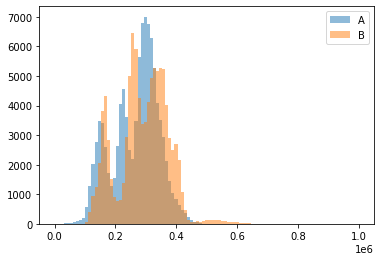

In [14]:
plt.figure()
pubrev_lo, pubrev_hi = 0e6, 1e6
_ = plt.hist(rvs_A, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="A")
_ = plt.hist(rvs_B, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="B")
plt.legend()

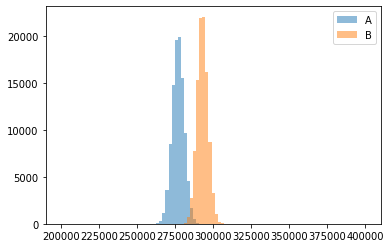

In [15]:
plt.figure()
pubrev_lo, pubrev_hi = 0.2e6, 0.4e6
_ = plt.hist(rvs_A_all, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="A")
_ = plt.hist(rvs_B_all, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="B")
plt.legend()

In [16]:
P_arr = []
P_all_arr = []
for hr in range(1, 25):
    
    rvs_A, rvs_A_all = plot_rvs(all_data, timeout=800, max_hour=hr, N=100000, verbose=False, use_global_mean=False)
    rvs_B, rvs_B_all = plot_rvs(all_data, timeout=1500, max_hour=hr, N=100000, verbose=False, use_global_mean=False)
    
    P = (rvs_A < rvs_B).sum() / len(rvs_B)
    P_all = (rvs_A_all < rvs_B_all).sum() / len(rvs_B_all)
    
    P_arr.append(P)
    P_all_arr.append(P_all)

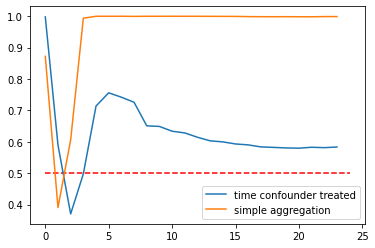

In [17]:
plt.plot(P_arr, label="time confounder treated")
plt.plot(P_all_arr, label="simple aggregation")
plt.hlines(0.5, 0, 24, colors='r', linestyles='--')
plt.legend()

# Subtract global mean

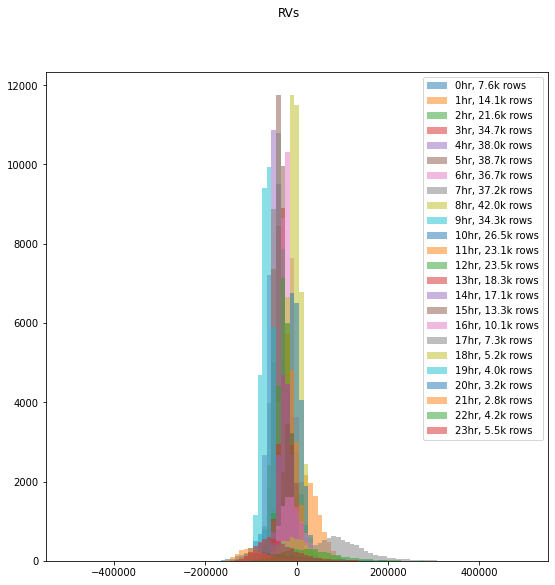

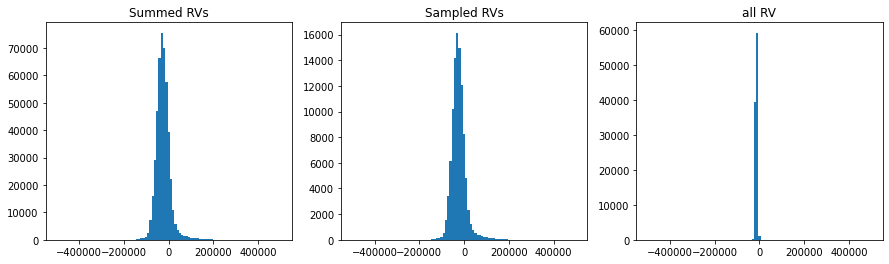

In [18]:
rvs_A, rvs_A_all = plot_rvs(all_data, timeout=800, max_hour=24, N=100000, verbose=True, 
                            pubrev_lo=-0.5e6, pubrev_hi=0.5e6, use_global_mean=True)

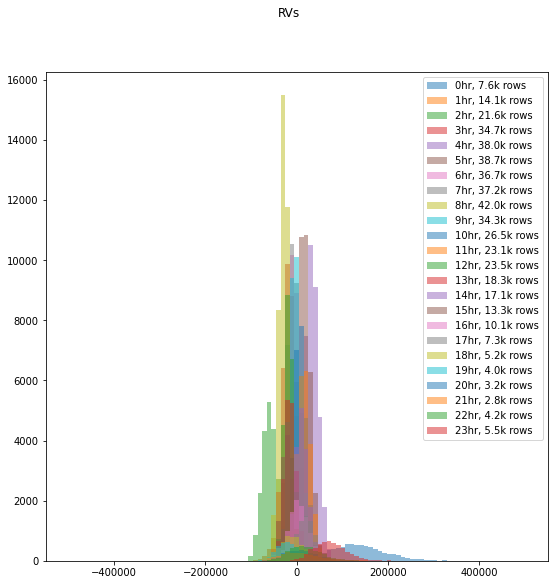

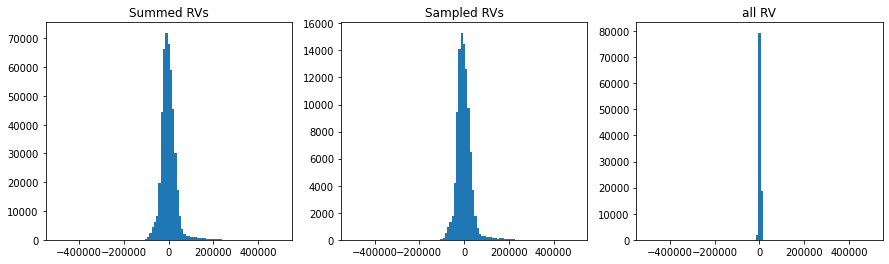

In [19]:
rvs_B, rvs_B_all = plot_rvs(all_data, timeout=1500, max_hour=24, N=100000, verbose=True, 
                            pubrev_lo=-0.5e6, pubrev_hi=0.5e6, use_global_mean=True)

In [20]:
P = (rvs_A < rvs_B).sum() / len(rvs_B)
print(f"Probability of B beating A: {P}")
P = (rvs_A_all < rvs_B_all).sum() / len(rvs_B_all)
print(f"Probability of B beating A (all): {P}")

Probability of B beating A: 0.73677
Probability of B beating A (all): 0.99889


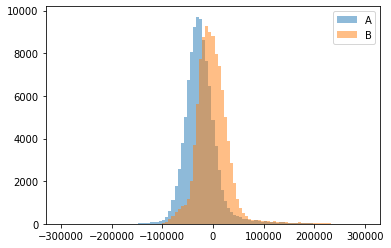

In [21]:
plt.figure()
pubrev_lo, pubrev_hi = -0.3e6, 0.3e6
_ = plt.hist(rvs_A, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="A")
_ = plt.hist(rvs_B, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="B")
plt.legend()

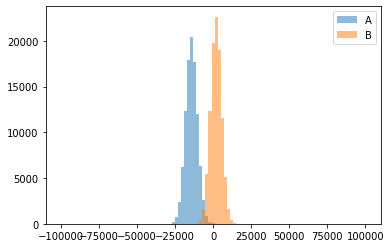

In [28]:
plt.figure()
pubrev_lo, pubrev_hi = -0.1e6, 0.1e6
_ = plt.hist(rvs_A_all, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="A")
_ = plt.hist(rvs_B_all, bins=np.linspace(pubrev_lo, pubrev_hi, 100), alpha=0.5, label="B")
plt.legend()

In [23]:
P_arr = []
P_all_arr = []
for hr in range(1, 25):
    
    rvs_A, rvs_A_all = plot_rvs(all_data, timeout=800, max_hour=hr, N=100000, verbose=False, use_global_mean=True)
    rvs_B, rvs_B_all = plot_rvs(all_data, timeout=1500, max_hour=hr, N=100000, verbose=False, use_global_mean=True)
    
    P = (rvs_A < rvs_B).sum() / len(rvs_B)
    P_all = (rvs_A_all < rvs_B_all).sum() / len(rvs_B_all)
    
    P_arr.append(P)
    P_all_arr.append(P_all)

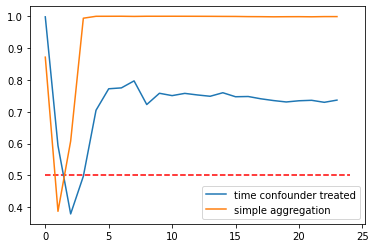

In [24]:
plt.plot(P_arr, label="time confounder treated")
plt.plot(P_all_arr, label="simple aggregation")
plt.hlines(0.5, 0, 24, colors='r', linestyles='--')
plt.legend()

# Compare all timeouts

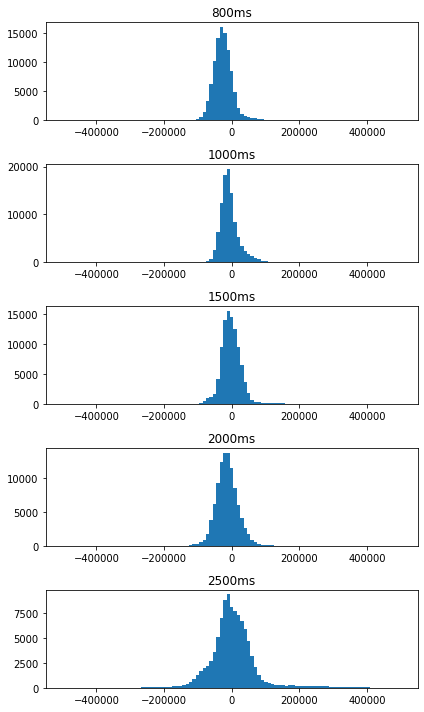

In [25]:
pubrev_lo=-0.5e6
pubrev_hi=0.5e6
fig, ax = plt.subplots(5, 1, figsize=(6, 10))
for idx, timeout in enumerate(timeouts[publisher]):
    rvs, _ = plot_rvs(all_data, timeout=timeout, max_hour=24, N=100000, verbose=False, use_global_mean=True,
                         pubrev_lo=pubrev_lo, pubrev_hi=pubrev_hi)
    
    ax[idx].hist(rvs, label=f"{timeout}ms", bins=np.linspace(pubrev_lo, pubrev_hi, 100))
    ax[idx].set_title(f"{timeout}ms")
fig.tight_layout()